In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from scipy.optimize import curve_fit
import math

# Surfactant library

In [2]:
surfactant_library = {
    "SDS": {
        "full_name": "Sodium Dodecyl Sulfate",
        "CAS": "151-21-3",
        "CMC": 8.5,
        "Category": "anionic",
        "MW": 289.39,
        "stock_conc": 50,  # mM
        "low": 7,
        "high": 10
    },


    "NaDC": {
        "full_name": "Sodium Docusate",
        "CAS": "577-11-7",
        "CMC": 5.3375,
        "Category": "anionic",
        "MW": 445.57,
        "stock_conc": 25,  # mM
        "low":2.48,
        "high": 8.2
    },

    
    "NaC": {
        "full_name": "Sodium Cholate",
        "CAS": "361-09-1",
        "CMC": 14,
        "Category": "anionic",
        "MW": 431.56,
        "stock_conc": 50,  # mM
        "low": 13,
        "high":15,
    },


    "CTAB": {
        "full_name": "Hexadecyltrimethylammonium Bromide",
        "CAS": "57-09-0",
        "CMC": 1.07,
        "Category": "cationic",
        "MW": 364.45,
        "stock_conc": 5, # mM
        "low": 0.9,
        "high": 1.24,
    },


    "DTAB": {
        "full_name": "Dodecyltrimethylammonium Bromide",
        "CAS": "1119-94-4",
        "CMC": 15.85,
        "Category": "cationic",
        "MW": 308.34,
        "stock_conc": 50,  # mM
        "low": 15.7,
        "high": 16
    },


    "TTAB": {
        "full_name": "Tetradecyltrimethylammonium Bromide",
        "CAS": "1119-97-7",
        "CMC": 3.985,
        "Category": "cationic",
        "MW": 336.39,
        "stock_conc": 50,  # mM
        "low": 3.77,
        "high": 4.2
    },

    "CAPB": {
        "full_name": "Cocamidopropyl Betaine",
        "CAS": "61789-40-0",
        "CMC": 0.627,
        "Category": "zwitterionic",
        "MW": 342.52,
        "stock_conc": 50,  # mM
        "low": 0.28,
        "high": 0.974
    },
    
    "CHAPS": {
        "full_name": "CHAPS",
        "CAS": "75621-03-3",
        "CMC": 8,
        "Category": "zwitterionic",
        "MW": 614.88,
        "stock_conc": 30,  # mM
        "low": 6,
        "high": 10
    }
}

SURFACTANT_ORDER = ['SDS', 'NaDC', 'NaC', 'CTAB', 'DTAB', 'TTAB', 'CAPB', 'CHAPS']

red = '#e64b35'
blue='#4dbbd5'

# Combine raw data

In [3]:
base_dirs = ['signle_CMC/20250702_1723', 'signle_CMC/20250703_1657', 'signle_CMC/20250704_1309']

pattern = re.compile(
    r'^(?P<prefix>output_data|wellplate_data)_'  
    r'[^_]+_[^_]+'                             
    r'_(?P<surfactant>[^_]+)'                  
    r'_(?P<time>\d+)min_'                       
    r'(?P<assay>[^_]+)'                         
    r'_rep(?P<replicate>\d+)\.csv$'             
)

# 1) Read & combine output_data
out_dfs = []
for base in base_dirs:
    for path in (Path(base) / 'raw_data').glob('output_data_*.csv'):
        m = pattern.match(path.name)
        if not m:
            continue
        surf = m.group('surfactant')
        t    = int(m.group('time'))
        assay  = m.group('assay')
        rep  = int(m.group('replicate'))

        df = pd.read_csv(path, usecols=['334_373', '334_384'])
        df['ratio']      = df['334_373'] / df['334_384']
        df['surfactant'] = surf
        df['assay']      = assay
        df['time']        = t
        df['replicate']   = rep
        out_dfs.append(df)

combined_raw = pd.concat(out_dfs, ignore_index=True)

# give each measurement a “row-within-group” index
combined_raw['well_idx'] = (
    combined_raw
      .groupby(['surfactant','time','assay','replicate'])
      .cumcount()
)

# 2) Read & combine wellplate_data (no averaging!)
well_dfs = []
for base in base_dirs:
    raw_dir = Path(base) / 'raw_data'
    for path in raw_dir.glob('wellplate_data_*.csv'):
        m = pattern.match(path.name)
        if not m:
            continue

        surf   = m.group('surfactant')
        t      = int(m.group('time'))
        assay  = m.group('assay')
        rep    = int(m.group('replicate'))

        wdf = pd.read_csv(path, usecols=['concentration'])
        wdf['surfactant'] = surf
        wdf['time']       = t
        wdf['assay']      = assay
        wdf['replicate']  = rep
        well_dfs.append(wdf)

well_meta = pd.concat(well_dfs, ignore_index=True)

# index each well‐plate row within its group
well_meta['well_idx'] = (
    well_meta
      .groupby(['surfactant','time','assay','replicate'])
      .cumcount()
)

# 3) Merge on the four keys: surfactant, time, replicate, and well_idx
combined_full = pd.merge(
    combined_raw,
    well_meta,
    on=['surfactant','time','assay','replicate','well_idx'],
    how='left'
).drop(columns='well_idx')

In [4]:
combined_full

,334_373,334_384,ratio,surfactant,assay,time,replicate,concentration
0,133296.0,167994.0,0.793457,NaDC,b,5,3,2.135000
1,121709.0,150630.0,0.808000,NaDC,b,5,3,2.756273
2,143249.0,175407.0,0.816666,NaDC,b,5,3,3.558333
3,153011.0,181410.0,0.843454,NaDC,b,5,3,4.003125
4,117571.0,146014.0,0.805204,NaDC,b,5,3,4.536875
...,...,...,...,...,...,...,...,...
4315,201879.0,301759.0,0.669007,CHAPS,c,20,2,9.200000
4316,221422.0,335694.0,0.659595,CHAPS,c,20,2,10.000000
4317,232806.0,358632.0,0.649150,CHAPS,c,20,2,12.000000
4318,228839.0,353533.0,0.647292,CHAPS,c,20,2,15.491933


In [5]:
combined_full.to_csv("processed_data/signle_CMC_data.csv", index=False)


# Figure 2

/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_15644/1729948712.py:3: RuntimeWarning: overflow encountered in exp
  return A2 + (A1 - A2) / (1 + np.exp((x - x0) / dx))


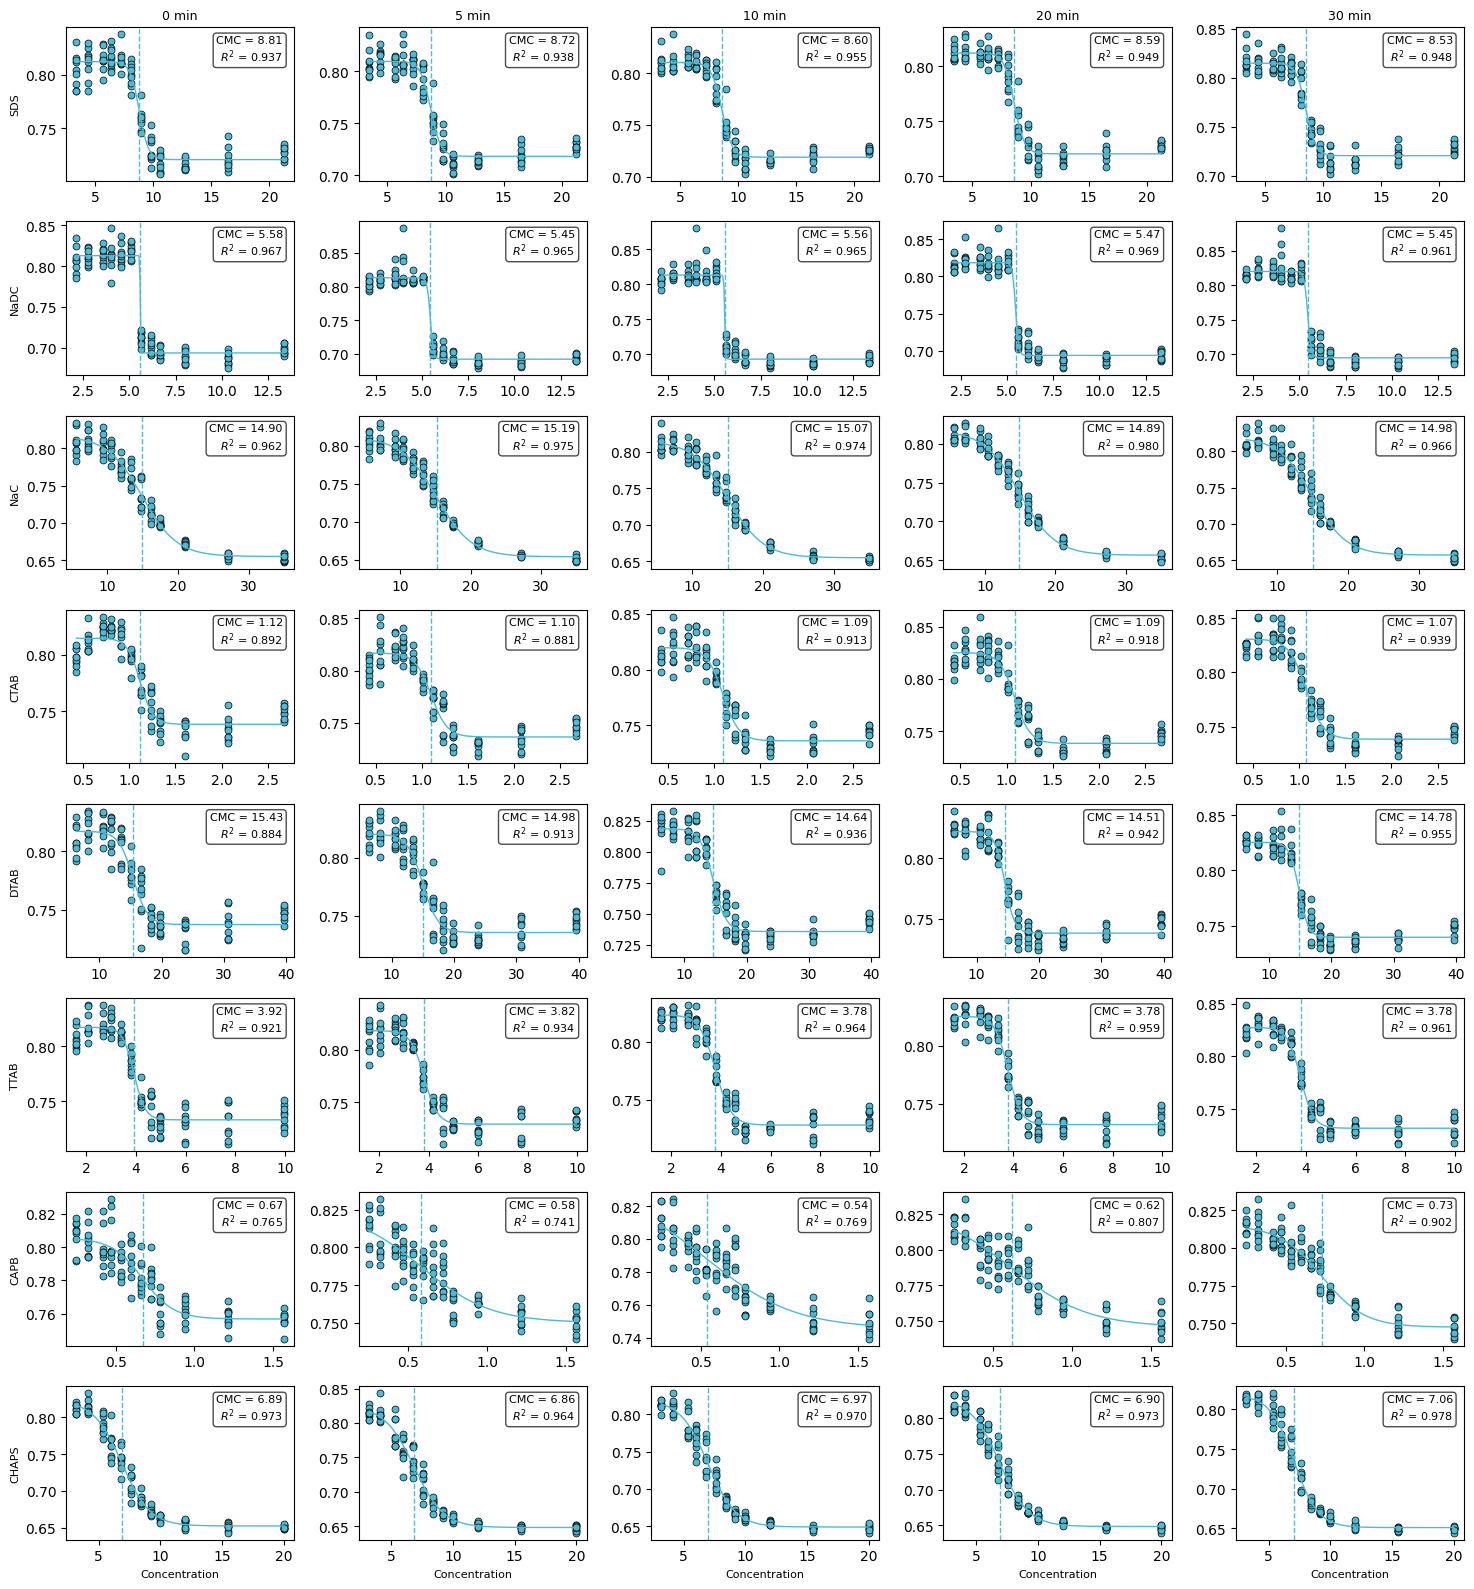

In [6]:
# Boltzmann sigmoidal function
def boltzmann(x, A1, A2, x0, dx):
    return A2 + (A1 - A2) / (1 + np.exp((x - x0) / dx))

# CMC_plot function as provided
def CMC_plot(ax, ratio, conc ,log=0, plot=1):

    if log:
        conc = np.log(conc)

    p0 = [
        max(ratio),
        min(ratio),
        (max(conc) + min(conc)) / 2,
        (max(conc) - min(conc)) / 5
    ]
    popt, _ = curve_fit(boltzmann, conc, ratio, p0, maxfev=5000)
    A1, A2, x0, dx = popt

    # compute R²
    residuals = ratio - boltzmann(conc, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ratio - np.mean(ratio))**2)
    r2 = 1 - ss_res / ss_tot

    if plot:
        # generate fit curve
        x_fit = np.linspace(min(conc), max(conc), 200)

        # scatter with blue face and thin black edge
        ax.scatter(
            conc, ratio,
            s=25,
            facecolors=blue,
            edgecolors='black',
            linewidth=0.5,
            label='Data'  # optional
        )

        # fitted Boltzmann curve in blue
        ax.plot(
            x_fit,
            boltzmann(x_fit, *popt),
            color=blue,
            lw=1,
            label='Fit'   # optional
        )

        # vertical CMC line in blue
        ax.axvline(
            x0,
            linestyle='--',
            color=blue,
            lw=1,
            label='CMC'   # optional
        )

        if log:
            x0 = math.exp(x0)

        # annotate stats
        ax.text(
            0.95, 0.95,
            f"CMC = {x0:.2f}\n$R^2$ = {r2:.3f}",
            transform=ax.transAxes, ha='right', va='top',
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white",
                    ec="black", alpha=0.7)
        )
    return x0, r2

COMBINE_ASSAYS = True   # ← set True to combine all assays before fitting
# ————————————————————

# Load data
df = combined_full.copy()

# Column mappings
I1_COL    = '334_373'
I3_COL    = '334_384'
RATIO_COL = 'ratio'
SURF_COL  = 'surfactant'
TIME_COL  = 'time'
ASSAY_COL = 'assay'
CONC_COL  = 'concentration'

# If needed:
# df[RATIO_COL] = df[I1_COL] / df[I3_COL]

# surfactant ordering
SURFACTANT_ORDER = ['SDS', 'NaDC', 'NaC', 'CTAB', 'DTAB', 'TTAB', 'CAPB', 'CHAPS']
df[SURF_COL] = pd.Categorical(df[SURF_COL],
                              categories=SURFACTANT_ORDER,
                              ordered=True)

times  = sorted(df[TIME_COL].unique())
assays = sorted(df[ASSAY_COL].unique())

# build combos depending on mode
if COMBINE_ASSAYS:
    combos = [(surf, None) for surf in SURFACTANT_ORDER]
else:
    combos = [
        (surf, assay)
        for surf in SURFACTANT_ORDER
        for assay in assays
        if not df[(df[SURF_COL] == surf) & (df[ASSAY_COL] == assay)].empty
    ]

n_rows = len(combos)
n_cols = len(times)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols*3, n_rows*2),
                         sharex=False, sharey=False)

for i, (surf, assay) in enumerate(combos):
    for j, t in enumerate(times):
        ax = axes[i, j] if n_rows>1 and n_cols>1 else axes[max(i,j)]

        # pick subset depending on mode
        if COMBINE_ASSAYS:
            subset = df[(df[SURF_COL]==surf) & (df[TIME_COL]==t)]
        else:
            subset = df[(df[SURF_COL]==surf) &
                        (df[ASSAY_COL]==assay) &
                        (df[TIME_COL]==t)]

        if not subset.empty:
            CMC_plot(ax,
                     subset[RATIO_COL].values,
                     subset[CONC_COL].values,
                     log=0, plot=1)
        else:
            ax.axis('off')

        # titles/labels
        if i == 0:
            ax.set_title(f"{t} min", fontsize=9)

        if j == 0:
            if COMBINE_ASSAYS:
                ax.set_ylabel(f"{surf}", fontsize=8)
            else:
                ax.set_ylabel(f"{surf}\nAssay {assay}", fontsize=8)

        if i == n_rows - 1:
            ax.set_xlabel("Concentration", fontsize=8)

plt.tight_layout()
#fig.savefig('Figure_2.png', dpi=300)
plt.show()


# Figure 3

In [7]:
def reliability_analysis(df,
                         surf_col='surfactant',
                         rep_col='replicate',
                         assay_col='assay',
                         time_col='time',
                         conc_col='concentration',
                         ratio_col='ratio'):

    # enforce surfactant as an ordered categorical
    df[surf_col] = pd.Categorical(df[surf_col],
                                  categories=SURFACTANT_ORDER,
                                  ordered=True)

    # — Step A: get one CMC per surf×rep×assay×time —
    records = []
    for surf in SURFACTANT_ORDER:
        sub_s = df[df[surf_col] == surf]
        if sub_s.empty:
            continue
        for rep in sub_s[rep_col].unique():
            for assay in sub_s[assay_col].unique():
                for t in sub_s[time_col].unique():
                    sub = sub_s[(sub_s[rep_col]==rep) &
                                (sub_s[assay_col]==assay) &
                                (sub_s[time_col]==t)]
                    if sub.empty:
                        continue
                    cmc, _ = CMC_plot(None,
                                      sub[ratio_col].values,
                                      sub[conc_col].values,
                                      log=0, plot=0)
                    records.append({
                        surf_col:  surf,
                        rep_col:   rep,
                        assay_col: assay,
                        time_col:  t,
                        'CMC':     cmc
                    })
    summary_df = pd.DataFrame.from_records(records)

    # helper for CV
    cv = lambda x: x.std()/x.mean() if len(x)>1 and x.mean()!=0 else np.nan

    # — Step B: compute CVs + mean/std per surfactant —
    out = []
    for surf, grp in summary_df.groupby(surf_col):
        # CV by replicate
        cv_rep = (grp
                  .groupby([assay_col, time_col])['CMC']
                  .apply(cv)
                  .dropna().mean())

        # CV by assay
        cv_assay = (grp
                    .groupby([rep_col, time_col])['CMC']
                    .apply(cv)
                    .dropna().mean())

        # CV by time
        cv_time = (grp
                   .groupby([rep_col, assay_col])['CMC']
                   .apply(cv)
                   .dropna().mean())

        # overall mean & std of all repeats
        mean_all = grp['CMC'].mean()
        std_all  = grp['CMC'].std()

        # overall CV
        cv_overall = std_all/mean_all if len(grp)>1 and mean_all!=0 else np.nan

        out.append({
            surf_col:         surf,
            'replicate CV': cv_rep,
            'assay CV':     cv_assay,
            'time CV':      cv_time,
            'overall CV':      cv_overall,
            'measured CMC':        mean_all,
            'measured CMC STD':         std_all
        })

    result = pd.DataFrame(out)

    # enforce row order
    result[surf_col] = pd.Categorical(
        result[surf_col],
        categories=SURFACTANT_ORDER,
        ordered=True
    )
    result = result.sort_values(by=surf_col).reset_index(drop=True)

    result['literature low']  = result[surf_col].map(lambda s: surfactant_library[s]['low'])
    result['literature high'] = result[surf_col].map(lambda s: surfactant_library[s]['high'])
    
    return result

In [8]:
table1 = reliability_analysis(combined_full)
table1 = table1.round(2)

table1.to_excel("Table_1.xlsx", index=False)
table1

/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_15644/1729948712.py:3: RuntimeWarning: overflow encountered in exp
  return A2 + (A1 - A2) / (1 + np.exp((x - x0) / dx))
/var/folders/hk/7jjnrbrj53n1t8_bmkhf0_k00000gn/T/ipykernel_15644/1729948712.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(boltzmann, conc, ratio, p0, maxfev=5000)


,surfactant,replicate CV,assay CV,time CV,overall CV,measured CMC,measured CMC STD,literature low,literature high
0,SDS,0.02,0.03,0.02,0.03,8.63,0.24,7.00,10.00
1,NaDC,0.01,0.01,0.01,0.02,5.50,0.09,2.48,8.20
2,NaC,0.03,0.04,0.03,0.04,14.99,0.64,13.00,15.00
3,CTAB,0.02,0.06,0.02,0.05,1.10,0.06,0.90,1.24
4,DTAB,0.03,0.03,0.04,0.04,14.87,0.65,15.70,16.00
5,TTAB,0.01,0.02,0.02,0.03,3.83,0.11,3.77,4.20
6,CAPB,-0.48,0.18,-13.27,-73.92,-0.02,1.68,0.28,0.97
7,CHAPS,0.03,0.09,0.03,0.08,6.86,0.54,6.00,10.00


In [9]:

SURFACTANT_ORDER = ['SDS', 'NaDC', 'NaC', 'CTAB', 'DTAB', 'TTAB', 'CAPB', 'CHAPS']

def plot_cmc_comparison(
    df,
    surfactant_order=SURFACTANT_ORDER,
    offset=0.1,
    measured_color = red,
    literature_color= blue,
    marker_size=8,
    line_width=4
):

    # Clean and filter names
    df_plot = df.copy()
    df_plot['surfactant'] = df_plot['surfactant'].astype(str).str.strip()
    df_plot = df_plot[df_plot['surfactant'].isin(surfactant_order)]

    fig, ax = plt.subplots(figsize=(8, len(surfactant_order)*0.45))

    for _, row in df_plot.iterrows():
        surf = row['surfactant']
        idx = surfactant_order.index(surf)
        mean, std = row['measured CMC'], row['measured CMC STD']
        lit_low, lit_high = row['literature low'], row['literature high']

        # Measured CMC range: fill with group color, border in black
        ax.plot(
            [mean - std, mean + std],
            [idx + offset, idx + offset],
            marker='o',
            markersize=marker_size,
            linewidth=line_width*0.6,
            color=measured_color,
            markerfacecolor=measured_color,
            markeredgecolor='black',
            label='Measured' if idx == 0 else ""
        )
        # Literature CMC range: fill with group color, border in black
        ax.plot(
            [lit_low, lit_high],
            [idx - offset, idx - offset],
            marker='o',
            markersize=marker_size,
            linewidth=line_width*0.6,
            color=literature_color,
            markerfacecolor=literature_color,
            markeredgecolor='black',
            label='Literature' if idx == 0 else ""
        )

    # Set y-ticks and labels, then invert y-axis so first item is at top
    ax.set_yticks(range(len(surfactant_order)))
    ax.set_yticklabels(surfactant_order)
    ax.invert_yaxis()

    ax.set_xlabel('CMC Value (mM)')

    # reverse the two labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])

    ax.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()

    return fig, ax




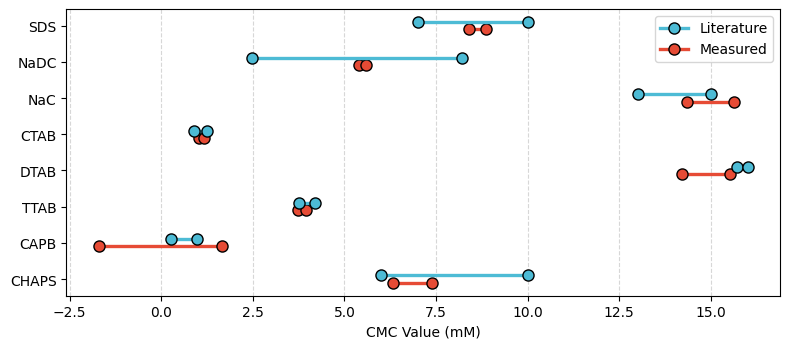

In [10]:
fig, ax = plot_cmc_comparison(table1)
# save the figure
fig.savefig('Figure_3.png', dpi=300)

plt.show()